Simulation for branching process with random mutation. Each time the pathogen transmits to a new person, it mutates (both beta and gamma are allowed to mutate independently).

There are 2 main functions, "sim" and "recurrent_sim".

"sim" represents a process without recurrent spillover. It seeds the population with an initial case (presumably spilled over from a reservoir). It branches until either the infection goes extinct or surpasses a threshold. In the latter case, we call it an outbreak. 

"recurrent_sim" represents a process with random recurrent spillover at some rate alpha. It begins with a single founding spillover case and branches it. Meanwhile, more spillovers arrive, each giving birth to a new branching process tree. Overall, the infection either surpasses an outbreak threshold, or it goes extinct (which requires a moment in time when ALL spillover processes have gone extinct - i.e. there are 0 infected people at that time). 

To dos: 
    - Make more graphs/visualizations.
    - Play with mutation rates.
            - Play with unequal mutation rates for beta and gamma
    - Play with spillover rate.
    - Include backwards transmission.
    - Try with a finite population.
    - Do a sanity check for the implementation of interevent time against Linda's slides.
    - Do a sanity check for the bulk recurrent simulation against the Voinson 2018 paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
###################################################
# simulates infection WITHOUT recurrent spillover 
# allows both gamma and beta to mutate            
#
# note: this implementation branches people in "generation order" instead of in "time order"
# (much faster to run, and still gives the same result in the limit as outbreak_thresh -> infinity)
# for an implementation done in time order, see the function sim_class
#
# also note that if the infection goes extinct the time of extinction is well-defined, and either implementation computes it correctly.
###################################################
#
# input beta_0 is transmission rate of the initial case.
# input gamma_0 is recovery rate of the initial case. 
#
# optional input mu_1 represents mutation rate for beta. If unspecified, defaults to 0.
# optional input mu_2 represents mutation rate for gamma. If unspecified, defaults to 0.
#
###################################################
#
# returns 0, t_ext if extinction, where t_ext is time of extinction. 
# returns 1 if outbreak
#
###################################################

def sim(beta_0, gamma_0, mu_1=0, mu_2=0):
    
    outbreak_thresh = 100 #call it an outbreak if this many people are infected
    
    t = 0
    
    #store active cases as an array of triples
    #each triple looks like [beta, gamma, time of infection] and represents one infected person
    infecteds=[[beta_0, gamma_0, t]]
    
    N_infected = len(infecteds) #keep track of number of infected people
    
    t_ext = None #time of extinction, will fill this value and return it if the infection goes extinct
    
    while True: 
        
        #print("\n", "infecteds now = ", infecteds)
        
        #keeps track of indices of recovered people
        #will delete them from array of infecteds at the end of each while loop iteration
        recovereds = []
        
        for i, person in enumerate(infecteds): #go through and branch each person in array of infecteds

            #print("\n", "branching person", i)
            
            [beta, gamma, t] = person
            
            while True:
                                
                #interevent time
                #note this is interevent time for ONE person, NOT for entire population
                dt = np.random.exponential(scale = 1/(beta + gamma))
                new_t = t + dt #time of new event
                
                #pick which new event happens, transmission or recovery         
                ev = np.random.rand() #draw number from uniform distribution over [0, 1)
                prob_trans = beta / (beta+gamma)

                if (ev < prob_trans): #transmission
                    
                    #print("person", i, " is transmitting")
                    
                    #pick beta and gamma for new case
                    #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
                    #don't allow negative beta.
                    #don't allow gamma to be less than a small value, the natural death rate.
                    mut1 = np.random.normal(loc=0.0, scale=mu_1)
                    new_beta = max(0, beta + mut1)
                    mut2 = np.random.normal(loc=0.0, scale=mu_2)              
                    nat_death = 0.00002366575 #taken from CDC: https://www.cdc.gov/nchs/fastats/deaths.htm & scaled to be daily rate instead of yearly
                    new_gamma = max(nat_death, gamma + mut2)
                    
                    #append new person to array of infecteds
                    infecteds = np.append(infecteds, [[new_beta, new_gamma, new_t]], axis=0)
                    N_infected += 1
                    
                    if N_infected >= outbreak_thresh:
                        #print("\n", "outbreak!")
                        return 1

                    #print("new infection: ", [new_beta, new_gamma, new_t])

                else: #recovery
                    
                    #print("person", i, " recovers") 
                    
                    N_infected -= 1
 
                    if N_infected == 0:
                        #print("\n", "extinction")
                        return 0, new_t
                    
                    #mark index of this recovered person, in order to delete them later
                    #(we don't delete yet, because that will mess up the indexing of the for loop)
                    recovereds.append(i)
                    break #skip to next person

        #after each time we complete a round of branching everybody:
        #update the array of infecteds by deleting recoveries
        infecteds = np.delete(infecteds, recovereds, axis=0)

In [3]:
#####################################################
# runs many simulations WITHOUT recurrent spillover #
#####################################################
#
# optional input N_sims is number of simulations to run.
#
# returns the percentage of those simulations that outbreak
#
#########################

def sim_percentage(beta_0, gamma_0, mu_1=0, mu_2=0, N_sims=1000):   
    N_outbreaks = 0  
    for i in range(N_sims):
        if sim(beta_0, gamma_0, mu_1, mu_2) == 1: N_outbreaks += 1
    return N_outbreaks/N_sims

In [4]:
# run a single simulation

#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.01
mu_2 = 0.01

sim(beta_0, gamma_0, mu_1, mu_2)

(0, 47.41042611686244)

In [5]:
# run a bulk simulation

#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1=0.0001
mu_2=0.0001

sim_percentage(beta_0, gamma_0, mu_1, mu_2, N_sims=10000)

0.0

In [6]:
#################################################################
# for a fixed mu, plots the probability of outbreak against R_0 #
#################################################################
#
# input mu = mu_1 = mu_2
#
# optional inputs R0_min, R0_max give range of R_0 to plot over.
# optional input N_points gives number of points to plot.
# optional inputs N_sims gives number of simulations to run per point.
#
################################################################

def prob_plot(mu, R0_min=0.001, R0_max=2.5, N_points = 75, N_sims=750):
    
    # Take some evenly spaced R_0 values
    # Note that it does matter what beta and gamma are, even if they give the same R_0. 
    # But here we're just fixing gamma to be 0.1
    # TO DO later: explore other choices.
    beta_range = np.linspace(R0_min/10, R0_max/10, N_points); gamma = 0.1
    
    # initialize arrays to be plotted
    R0 = []; percent = []

    #simulate percentages of outbreak
    for beta in beta_range:
        R0 = np.append(R0, beta/gamma)
        percent = np.append(percent, sim_percentage(beta, gamma, mu, mu, N_sims))
        
    #make the plot
    plt.plot(R0, percent, "ob")
    #graph the actual probability of outbreak with no mutation
    #################################################################
    # From Linda's talk: the actual probability of outbreak with no mutation is:
    #                            0 if R_0 < 1
    #                            1-1/R_0 = 1-gamma/beta if R_0 > 1
    #################################################################
    plt.plot(R0, np.piecewise(R0, [R0<1, R0>=1], [0, lambda R0: 1-1/R0]), "r", label='probability without mutation')
    plt.title('mu1 = mu2 = {}'.format(mu))
    plt.xlabel("R_0"); plt.ylabel("p")
    plt.xlim(R0_min, R0_max)
    plt.legend()
    plt.show()

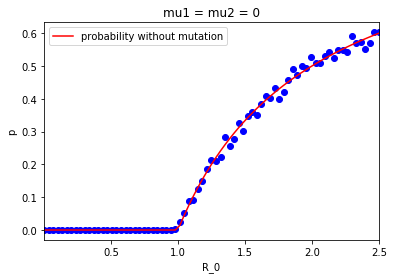

CPU times: user 1min 29s, sys: 600 ms, total: 1min 30s
Wall time: 1min 33s


In [216]:
%%time

# SANITY CHECK
# When there is no mutation, check that our simulation agrees with the correct probability

prob_plot(mu=0)

Simulate some other values of mu. Note the scale changes on the axes

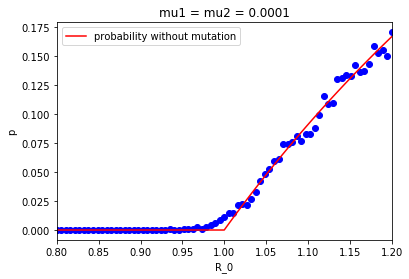

In [59]:
#zoom in
prob_plot(mu=0.0001, R0_min=0.8, R0_max=1.2, N_points = 75, N_sims=2000)

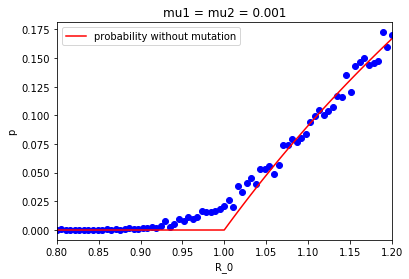

In [60]:
prob_plot(mu=0.001, R0_min=0.8, R0_max=1.2, N_points = 75, N_sims=2000)

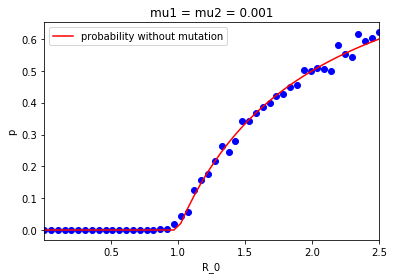

In [43]:
#zoom back out
prob_plot(mu=0.001)

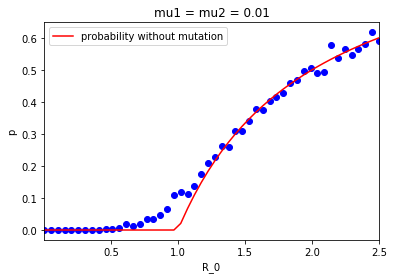

In [44]:
prob_plot(mu=0.01)

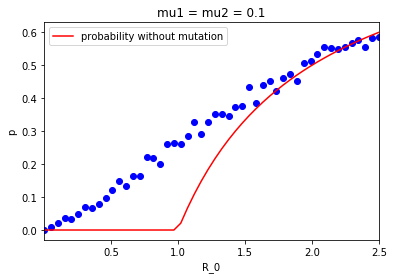

In [45]:
prob_plot(mu=0.1)

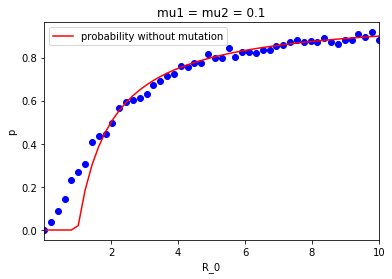

In [46]:
#zoom out more
prob_plot(mu=0.1, R0_max=10)

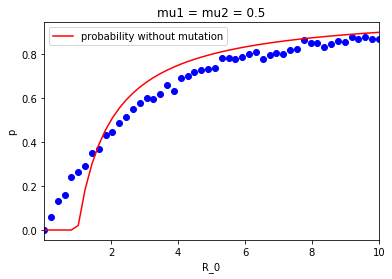

In [49]:
prob_plot(mu=0.5, R0_max=10)

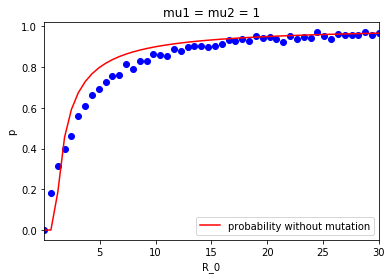

In [61]:
prob_plot(mu=1, R0_max=30)

Here is some space to play with other values of mu_1 and mu_2

In [7]:
#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.01
mu_2 = 0.01

sim_percentage(beta_0, gamma_0, mu_1, mu_2, N_sims=1000)

0.057

The next part generates some more graphs and visualizations.

In [217]:
#class representing one simulation.
#an instance of this class contains enough information to plot some pictures.
#the return value for sim_class and for recurrent_sim_class is an instance of this class. 

class Sim:
    def __init__(self, outcome, times, betas, gammas, N_infecteds):
        
        #0 if extinction, 1 if outbreak, None otherwise. 
        #(note sim_class will always return 0 or 1 here, but recurrent_sim_class may return None)
        self.outcome = outcome 
        
        #the remaining are all arrays of the same length
        self.t = times #all the times of new events (infections and recoveries, including spillover infections)
        self.betas = betas #the corresponding betas. if the event was a recovery, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was a recovery, the corresponding gamma is "None"
        self.N = N_infecteds #the number of infecteds, inclusive of the new event
        
        #TO DO: incorporate error checking.
        #for instance, make sure when instantiating that beta and gamma values corresponding to recoveries are None, otherwise throw an error.
    
    #returns the number of events in the simulation
    def length(self):
        return len(self.t) # note this is = len(self.betas) = len(self.gammas)= len(self.N)
    
    #returns the ith event [t, beta, gamma, N]
    def event(self, i):
        return np.array([self.t[i], self.betas[i], self.gammas[i], self.N[i]])
    
    #truncate everything after time t_thresh
    def truncate(self, t_thresh):      
        for i in range(self.length()):
            if self.t[i] > t_thresh:
                self.t = self.t[:i]
                self.betas = self.betas[:i]
                self.gammas = self.gammas[:i]
                self.N = self.N[:i]
                break
        

In [78]:
#############################################################
# version of sim which 
#    1. is implemented in "time order" instead of "generation order"
#        (this makes it slower to run, but it's needed in order to make accurate plots)
#    2. returns an element of the class Sim.
#############################################################

def sim_class(beta_0, gamma_0, mu_1=0, mu_2=0):
    
    outbreak_thresh = 100 #call it an outbreak if this many people are infected
    
    t=0
        
    #stuff to fill and return as part of Sim object.
    all_times = np.array([t])
    all_betas = np.array([beta_0])
    all_gammas = np.array([gamma_0])
    all_N = np.array([1])
    
    N = 1 #initialize variable to keep track of total number of infected
        
    #initialize variables to keep track of sums of beta and gamma over all currently infected people    
    beta_sum = beta_0; gamma_sum = gamma_0
        
    #initialize matrix of active cases. each case is a row of length 3.
    # each row looks like [beta, gamma, time of infection] of that person. 
    infecteds=np.array([[beta_0, gamma_0, t]])
    
    while True:
        
        #grab array of all betas and array of all gammas
        betas = infecteds[:,0]; gammas = infecteds[:,1]
        
        #compute interevent time (for the whole population)
        
        #rate of events is sum of beta and gamma over all infected people
        overall_rate = beta_sum + gamma_sum
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate)
        t += dt
        
        #figure out who the event happened to
        i = np.random.choice(N, p=(betas+gammas)/overall_rate) #index of that person
        
        #grab their specific beta and gamma
        beta = betas[i]; gamma = gammas[i]
        
        #figure out what they did, transmit or recover. 
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = beta / (beta + gamma) #probability of transmission

        if (ev < prob_trans): #transmission

            #pick beta and gamma for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
            #don't allow negative beta.
            #don't allow gamma to be less than a small value, the natural death rate.
            mut1 = np.random.normal(loc=0.0, scale=mu_1)
            new_beta = max(0, beta + mut1)
            mut2 = np.random.normal(loc=0.0, scale=mu_2)              
            nat_death = 0.00002366575 #taken from CDC: 
                #https://www.cdc.gov/nchs/fastats/deaths.htm & scaled to be daily rate instead of yearly
            new_gamma = max(nat_death, gamma + mut2)

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[new_beta, new_gamma, t]], axis=0)
            
            #update the sums of beta and gamma
            beta_sum += new_beta; gamma_sum += new_gamma
            
            #update N
            N += 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, new_beta)
            all_gammas = np.append(all_gammas, new_gamma)
            all_N = np.append(all_N, N)

            #check if we have an outbreak
            if N >= outbreak_thresh:
                #print("\n", "outbreak!")
                return Sim(1, all_times, all_betas, all_gammas, all_N)

        else: #recovery
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update the sums of beta and gamma
            beta_sum -= betas[i]; gamma_sum -= gammas[i]
            
            #update N
            N -= 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, None)
            all_gammas = np.append(all_gammas, None)
            all_N = np.append(all_N, N)

            #check if we have extinction       
            if N == 0:
                #print("\n", "extinction")
                return Sim(0, all_times, all_betas, all_gammas, all_N)

0


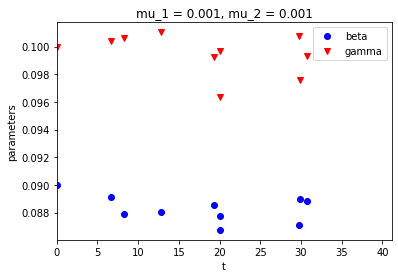

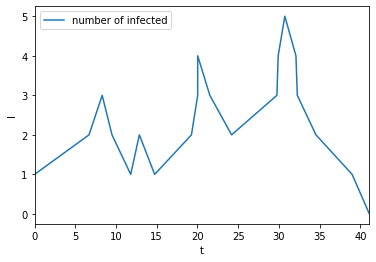

In [13]:
#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.001
mu_2 = 0.001

s = sim_class(beta_0, gamma_0, mu_1, mu_2)

print(s.outcome)
        
times = s.t; betas = s.betas; gammas = s.gammas; N_infecteds = s.N

max_time=max(times)

#plot betas and gammas over time
plt.plot(times, betas, "ob", label='beta'); plt.plot(times, gammas, "vr", label='gamma')
plt.title('mu_1 = {}, mu_2 = {}'.format(mu_1, mu_2))
plt.xlabel("t"); plt.ylabel("parameters")
plt.xlim(0, max_time)
plt.legend(); plt.show()

#plot N_infecteds over time
plt.plot(times, N_infecteds, label='number of infected')
plt.xlabel("t"); plt.ylabel("I")
plt.xlim(0, max_time)
plt.legend(); plt.show()

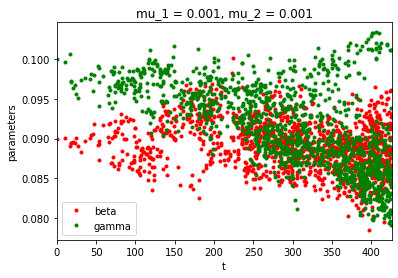

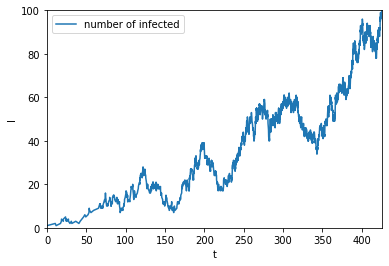

In [205]:
#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.001
mu_2 = 0.001

s = None

while True:
    s = sim_class(beta_0, gamma_0, mu_1, mu_2)
    if s.outcome == 1: break #get an outbreak
    #if s.t[-1] > 500: break #get a simulation where the disease spreads for at least this many days
        
times = s.t; betas = s.betas; gammas = s.gammas; N_infecteds = s.N

#plot betas and gammas over time
plt.plot(times, betas, ".r", label='beta'); plt.plot(times, gammas, ".g", label='gamma')
plt.title('mu_1 = {}, mu_2 = {}'.format(mu_1, mu_2))
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(); plt.show()

#plot N_infecteds over time
plt.plot(times, N_infecteds, label='number of infected')
plt.xlabel("t"); plt.ylabel("I")
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0, 100)
plt.legend(); plt.show()

Simulations WITH Recurrent Spillover

In [218]:
################################################
# simulates infection WITH recurrent spillover 
#
# this implementation is in "generation order" since it calls on the function sim.
# furthermore, each entire spillover tree is simulated before moving on to the next tree.
# for a "time order" implementation, see recurrent_sim_class.
#
################################################
#
# input alpha = spillover rate.
#
# inputs beta_0, gamma_0, mu_1, mu_2 are the same as in the function sim from above
#
# there are two hidden inputs max_t_ext, t_s, which you should ignore. (do NOT pass in any values for these.)
# they are only used implicitly when this function recursively calls itself.
#
################################################
#
# returns 1 if outbreak
# returns 0 if extinction
#
################################################
#
# TO DO: when alpha > 0, there may be the possibility of endemicity. 
# Right now, this function only terminates at outbreak or extinction. Need to fix this in the future.
# See recurrent_sim_class for an implementation which terminates after a certain maximum simulated number of days.
#
################################################

def recurrent_sim(alpha, beta_0, gamma_0, mu_1=0, mu_2=0, max_t_ext=0, t_s=0): 
    
    # hidden input max_t_ext keeps track of maximum extinction time seen so far
    # hidden input t_s keeps track of most recent time of spillover
    
    # simulate tree from a new spillover event
    sim_output = sim(beta_0, gamma_0, mu_1, mu_2)

    # if it outbreaks, we are done
    if sim_output == 1:
        
        #print("\n", "outbreak!")
        return 1
    
    # otherwise, that tree goes extinct
    # but we need to check whether any other spillovers happened in the meantime
    else:
        
        #print("max_t_ext updating, = max of ", max_t_ext, "and", sim_output[1])
        max_t_ext = max(max_t_ext, sim_output[1]) #update max extinction time, if necessary
        
       #if alpha is 0, no more spillovers ever occur. we are done.
        if alpha == 0: 
            return 0
        
        #otherwise, generate time of next spillover
        dt_s = np.random.exponential(scale=1/alpha) #inter-spillover time
        t_s += dt_s #time of next spillover
        #print("time of spillover is t_s = ", t_s)

        # if spillover occurs soon enough, we have to simulate another tree. recurse.
        if t_s < max_t_ext: 
            
            #print("a spillover occured! Recursing...")
            return recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2, max_t_ext, t_s)

        # if spillover occurs too late, we are done.
        else: 
            
            #print("next spillover too late. extinction!")
            return 0

In [16]:
##################################################
# runs many simulations WITH recurrent spillover #
##################################################
#
# returns the percentage of them that outbreak
#
##################################################

def recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1 = 0, mu_2 = 0, N_sims=100): 
    N_outbreaks = 0
    for i in range(N_sims):
        if recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2) == 1: 
                N_outbreaks += 1
    return N_outbreaks/N_sims

In [17]:
# run a single simulation

#parameters
alpha = 0.1
beta_0 = 0.09
gamma_0 = 0.1

recurrent_sim(alpha, beta_0, gamma_0)

0

In [18]:
%%time
# run a bulk simulation

#parameters
alpha = 0.01
beta_0 = 0.09
gamma_0 = 0.01
mu_1=0.001
mu_1=0.001

recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1, mu_1, N_sims=1000)

CPU times: user 2.18 s, sys: 58 ms, total: 2.24 s
Wall time: 2.34 s


0.888

In [19]:
###########################################################################
# for a fixed mu and alpha, plots the probability of outbreak against R_0 #
###########################################################################
#
# input alpha
# input mu = mu_1 = mu_2
#
# optional inputs R0_min, R0_max give range of R_0 to plot over.
# optional input N_points gives number of points to plot.
# optional inputs N_sims gives number of simulations to run per point.
#
##########################################################################

def recurrent_prob_plot(alpha, mu, R0_min=0.001, R0_max=2.5, N_points = 75, N_sims=750):
    
    # Take some evenly spaced R_0 values
    # Note that it does matter what beta and gamma are, even if they give the same R_0. 
    # But here we're just fixing gamma to be 0.1
    # TO DO later: explore other choices.
    beta_range = np.linspace(R0_min/10, R0_max/10, N_points); gamma = 0.1
    
    # initialize arrays to be plotted
    R0 = []; percent = []

    #simulate percentages of outbreak
    for beta in beta_range:
        R0 = np.append(R0, beta/gamma)
        percent = np.append(percent, recurrent_sim_percentage(alpha, beta, gamma, mu, mu, N_sims))
        
    #make the plot
    plt.plot(R0, percent, "ob")
    #graph the actual probability of outbreak with no mutation and no recurrent spillover
    #####################################################################################
    # From Linda's talk:
    #                            0 if R_0 < 1
    #                            1-1/R_0 = 1-gamma/beta if R_0 > 1
    #####################################################################################
    plt.plot(R0, np.piecewise(R0, [R0<1, R0>=1], [0, lambda R0: 1-1/R0]), "r", label='probability without mutation')
    plt.title('alpha = {}, mu1 = mu2 = {}'.format(alpha, mu))
    plt.xlabel("R_0"); plt.ylabel("p")
    plt.xlim(R0_min, R0_max)
    plt.legend()
    plt.show()

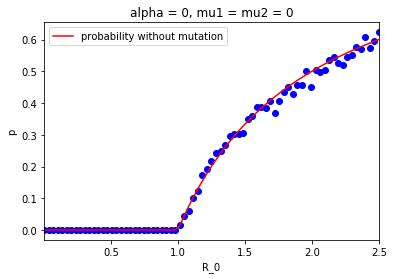

CPU times: user 1min 29s, sys: 652 ms, total: 1min 30s
Wall time: 1min 33s


In [219]:
%%time 

#########################
# SANITY CHECK 2 
# When there is no mutation, and no spillover, check that our simulation agrees with known results.
#########################

recurrent_prob_plot(alpha=0, mu=0)

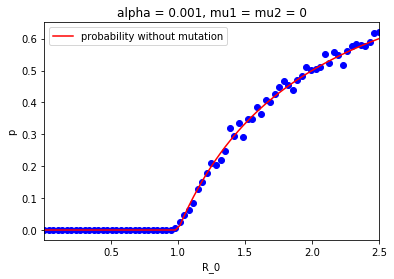

CPU times: user 1min 45s, sys: 847 ms, total: 1min 46s
Wall time: 1min 53s


In [287]:
%%time
recurrent_prob_plot(alpha=0.001, mu=0)

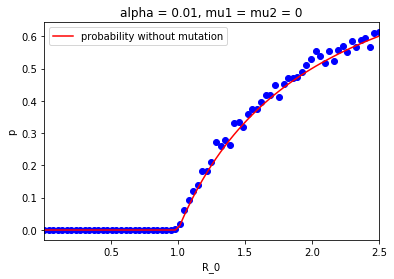

CPU times: user 1min 34s, sys: 440 ms, total: 1min 34s
Wall time: 1min 35s


In [288]:
%%time
recurrent_prob_plot(alpha=0.01, mu=0)

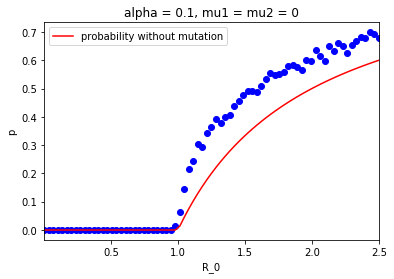

CPU times: user 2min 25s, sys: 1.01 s, total: 2min 26s
Wall time: 2min 30s


In [289]:
%%time
recurrent_prob_plot(alpha=0.1, mu=0)

In [243]:
################################################
#
# version of recurrent_sim which returns an element of the class Sim.
#
# will run until either we get an outbreak, or the simulation times out at specified threshold time.
# there is one other option, which occurs only if alpha = 0 and the infection goes extinct.
# (when alpha > 0, we will keep running, instead of stopping, at an extinction time.)
#
################################################
#
# optional input t_thresh is the maximum number of simulated days to run.
# optional input outbreak_thresh. we call it an outbreak if this many people are infected 
#
# returns an instance of the class Sim.
# the return object will be "None" for self.outcome if the simulation timed out by hitting the threshold time. 
# otherwise if we had an outbreak, self.outcome will be 1.
# finally, if alpha=0 and we had extinction, self.outcome will be 0.
#
#################################################

def recurrent_sim_class(alpha, beta_0, gamma_0, mu_1, mu_2, t_thresh = 1000, outbreak_thresh = 100):
    
    t=0
        
    #stuff to fill and return as part of Sim object.
    all_times = np.array([t])
    all_betas = np.array([beta_0])
    all_gammas = np.array([gamma_0])
    all_N = np.array([1])
    
    N = 1 #initialize variable to keep track of total number of infected
        
    #initialize variables to keep track of sums of beta and gamma over all currently infected people    
    beta_sum = beta_0
    gamma_sum = gamma_0
        
    #initialize matrix of active cases. each case is a row of length 3.
    # each row looks like [beta, gamma, time of infection] of that person. 
    infecteds=np.array([[beta_0, gamma_0, t]])
    
    while True:
        
        #grab array of all betas and array of all gammas
        betas = infecteds[:,0]
        gammas = infecteds[:,1]
        
        #compute interevent time (for the whole population)
        #rate of events is = alpha + (sum of beta and gamma over all infected people)
        overall_rate = beta_sum + gamma_sum + alpha
        
        #if alpha = 0 and we had extinction
        if alpha == 0 and N == 0:
            #print("extinction")
            return Sim(0, all_times, all_betas, all_gammas, all_N)
        
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate)
        t += dt
        
        #check if we exceeded t_thresh
        if t > t_thresh:
            #print('exceeded t_thresh')
            return Sim(None, all_times, all_betas, all_gammas, all_N)
        
        #figure out whether the event was a new spillover
        event = np.random.rand() #draw from uniform distribution over [0, 1)
        p_spillover = alpha/overall_rate
            
        if event < p_spillover: #new spillover

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[beta_0, gamma_0, t]], axis=0)

            #update the sums of beta and gamma
            beta_sum += beta_0; gamma_sum += gamma_0

            #update N
            N += 1

            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, beta_0)
            all_gammas = np.append(all_gammas, gamma_0)
            all_N = np.append(all_N, N)

            #check if we have an outbreak
            if N >= outbreak_thresh:
                #print("outbreak!")
                return Sim(1, all_times, all_betas, all_gammas, all_N)

            continue #skip to next event
        
        #otherwise, the event was that somebody either transmitted or recovered
        
        #figure out which person that was
        i = np.random.choice(N, p=(betas+gammas)/(overall_rate-alpha)) #index of that person
        
        #grab their specific beta and gamma
        beta = betas[i]; gamma = gammas[i]
        
        #figure out what they did, transmit or recover. 
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = beta / (beta + gamma) #probability of transmission

        if (ev < prob_trans): #transmission

            #pick beta and gamma for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
            #don't allow negative beta.
            #don't allow gamma to be less than a small value, the natural death rate.
            mut1 = np.random.normal(loc=0.0, scale=mu_1)
            new_beta = max(0, beta + mut1)
            mut2 = np.random.normal(loc=0.0, scale=mu_2)              
            nat_death = 0.00002366575 #taken from CDC: 
                #https://www.cdc.gov/nchs/fastats/deaths.htm & scaled to be daily rate instead of yearly
            new_gamma = max(nat_death, gamma + mut2)

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[new_beta, new_gamma, t]], axis=0)
            
            #update the sums of beta and gamma
            beta_sum += new_beta; gamma_sum += new_gamma
            
            #update N
            N += 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, new_beta)
            all_gammas = np.append(all_gammas, new_gamma)
            all_N = np.append(all_N, N)

            #check if we have an outbreak
            if N >= outbreak_thresh:
                #print("\n", "outbreak!")
                return Sim(1, all_times, all_betas, all_gammas, all_N)

        else: #recovery
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update the sums of beta and gamma
            beta_sum -= betas[i]; gamma_sum -= gammas[i]
            
            #update N
            N -= 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, None)
            all_gammas = np.append(all_gammas, None)
            all_N = np.append(all_N, N)

outcome =  None
times =  [0.00000000e+00 1.52011027e+00 1.42251971e+02 ... 9.85516482e+03
 9.85617304e+03 9.86383189e+03]


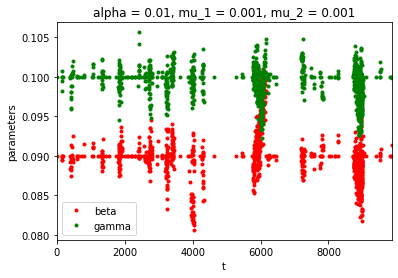

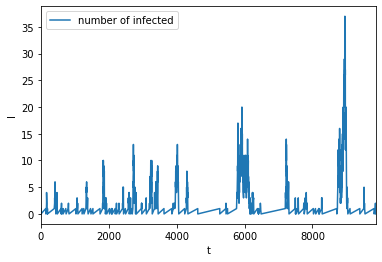

In [245]:
#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.001
mu_2 = 0.001
alpha = 0.01

t_thresh = 10000
outbreak_thresh = 100

#s = recurrent_sim_class(alpha, beta_0, gamma_0, mu_1, mu_2, t_thresh=t_thresh, outbreak_thresh = outbreak_thresh)

s = None

while True:
    s = recurrent_sim_class(alpha, beta_0, gamma_0, mu_1, mu_2, t_thresh=t_thresh, outbreak_thresh = outbreak_thresh)
    if s.outcome == None: break #get a timed out simulation
    #if s.t[-1] > 10: break #get a simulation where the disease spreads for at least this many days
        
times = s.t; betas = s.betas; gammas = s.gammas; N_infecteds = s.N

print("outcome = ", s.outcome)
print("times = ", s.t)

times = s.t; betas = s.betas; gammas = s.gammas; N_infecteds = s.N

#plot betas and gammas over time
plt.plot(times, betas, ".r", label='beta'); plt.plot(times, gammas, ".g", label='gamma')
plt.title('alpha = {}, mu_1 = {}, mu_2 = {}'.format(alpha, mu_1, mu_2))
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(); plt.show()

#plot N_infecteds over time
plt.plot(times, N_infecteds, label='number of infected')
plt.xlabel("t"); plt.ylabel("I")
plt.autoscale(enable=True, axis='x', tight=True)
#plt.ylim(0, 50)
plt.legend(); plt.show()

In [45]:
#





























#